In [2]:
import os
os.chdir('/home/aadi/projects/fire-bot/data/modis')

In [2]:
# from cupy import array
import numpy as cp
from numpy import array
import tensorflow as tf
from numpy import array
import matplotlib.pyplot as plt
from osgeo import gdal
import cv2 
import rasterio as rs
import georaster
from rasterio.plot import show
import cv2
from PIL import Image

import geopandas
import os
import matplotlib.pyplot as plt

from util.transforms import get_latlong, tif_to_array
# import libtiff
import numpy as np
# from libtiff import TIFF
# import tifffile

In [3]:
# get list of all folders in directory 
os.listdir()

['dist_terra_09.tif.npy',
 'fire_npy',
 'dist_terra_10.tif.npy',
 'fire',
 'lstgeotiff',
 'dist_terra_07.tif.npy',
 'dist_terra_08.tif.npy',
 '.ipynb_checkpoints',
 'dist_terra_05.tif.npy',
 'lst',
 'dist_terra_06.tif.npy']

In [4]:
# store file lists as file paths 
fire_fp = sorted(['fire/' + i for i in os.listdir('fire')])
lst_fp = sorted(['lstgeotiff/' + i for i in os.listdir('lstgeotiff')])

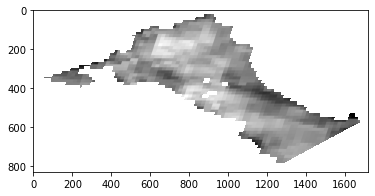

In [5]:
# ensure images are being read correctly
# plt.imshow(tif_to_array(lst_fp[1])*0.02)
img = tif_to_array(lst_fp[1])*0.02
# img[np.isnan(img)] = 0
img.max()
plt.imshow(img, cmap="gray")

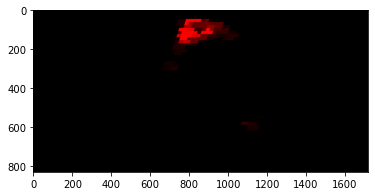

In [6]:
# ensure images are being read correctly
# plt.imshow(tif_to_array(lst_fp[1])*0.02)
img = tif_to_array(fire_fp[4])
# img[np.isnan(img)] = 0
img.max()
# img.shape = (3, 829, 1719)
img = np.moveaxis(img, 0, 2)
plt.imshow(img)

Have to calculate proximity to nearest fire pixel across every pixel, set zero for pixels on fire

In [7]:
# read all images into numpy arrays
for f in range(len(fire_fp)):
    temp = tif_to_array(fire_fp[f])
    temp = np.moveaxis(temp, 0, 2)
    fire_fp[f] = (fire_fp[f], temp) 

for f in range(len(lst_fp)):
    temp = lst_fp[f]
    lst_fp[f] = (temp, cp.asarray(tif_to_array(lst_fp[f])*0.02))


In [8]:
lst_fp

[('lstgeotiff/aqua_04.tif',
  array([[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]])),
 ('lstgeotiff/aqua_05.tif',
  array([[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]])),
 ('lstgeotiff/aqua_06.tif',
  array([[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]])),
 ('lstgeotiff/aqua_07.tif',
  array([

In [9]:
import copy
# take each image, start with empty array of -1
# find distance to closest fire-pixel for every other pixel
# mask out this DIST array using nan values (representing water/non-land)

def gen_fire_dist(img: array, nans: array) -> array:
    # convert 3-channel into single channel taking mean of values
    img = img.mean(axis=2)
    # binarize image
    img[img != 0] = 1
    # Find the indices of array elements that are non-zero, grouped by element.
    idx = np.argwhere(img)
    
    # linear search
    WIDTH, HEIGHT = img.shape
    dist = cp.zeros(img.shape)
    for x in range(WIDTH):
        for y in range(HEIGHT):
            if not cp.isnan(nans[x, y]):
                nearest_x, nearest_y = idx[((idx - [x,y])**2).sum(1).argmin()]
                dist[x,y] = cp.sqrt(cp.square(nearest_x - x) + cp.square(nearest_y - y))
                
    return dist
    

d = gen_fire_dist(fire_fp[31][1], lst_fp[5][1])

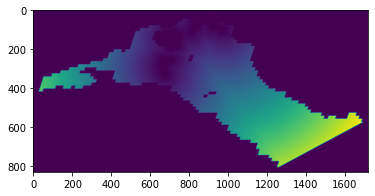

In [10]:
# ensuring above works
# brighter areas further from fires
plt.imshow(d)

In [11]:
from collections import namedtuple

ImagePair = namedtuple('ImagePair', ['filename','lst', 'fire'])
files = []
for (filename, file) in lst_fp:
    for (filename_fire, file_fire) in fire_fp:
        if filename.endswith(filename_fire.split('/')[-1]):
            files.append(ImagePair(filename_fire.split('/')[-1], file, file_fire))

In [12]:
distarrays = []
for file in files:
    print(file[0])
    try:
        dist = gen_fire_dist(file[2], file[1])
        distarrays.append((file[0], dist))
    except Exception as e:
        print(e)

aqua_04.tif
attempt to get argmin of an empty sequence
aqua_05.tif
aqua_06.tif
aqua_07.tif
aqua_08.tif
aqua_09.tif
aqua_10.tif
aqua_11.tif
attempt to get argmin of an empty sequence
aqua_12.tif
attempt to get argmin of an empty sequence
aqua_13.tif
attempt to get argmin of an empty sequence
aqua_14.tif
attempt to get argmin of an empty sequence
aqua_15.tif
attempt to get argmin of an empty sequence
aqua_16.tif
attempt to get argmin of an empty sequence
aqua_17.tif
attempt to get argmin of an empty sequence
aqua_18.tif
attempt to get argmin of an empty sequence
aqua_19.tif
attempt to get argmin of an empty sequence
aqua_20.tif
attempt to get argmin of an empty sequence
aqua_21.tif
attempt to get argmin of an empty sequence
aqua_22.tif
attempt to get argmin of an empty sequence
aqua_23.tif
attempt to get argmin of an empty sequence
aqua_24.tif
attempt to get argmin of an empty sequence
aqua_25.tif
attempt to get argmin of an empty sequence
aqua_26.tif
attempt to get argmin of an empty se

In [13]:
distarrays[0]

('aqua_05.tif',
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

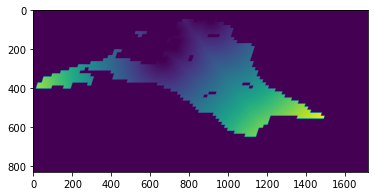

In [14]:
# distarrays holds distance to nearest fire pixel
plt.imshow(distarrays[5][1])

<font color='Orange'>2021-10-06</font>
- Completed generation of nearest-distance-to fire pixel and stored in arrays (float64) in metres
- Completed loading lst
- Masked nearest-distance using original nan-populated values (so water is zero), may be an issue

<font color='Red'>TODO</font>
Model for probability of fire in evening (**AQUA**) images given fire/not fire previously
Prior distribution binomial conditioned on (tentatively) normal

- [x] Determine whether normal distribution is appropriate for this


In [15]:
len(distarrays)
for file in distarrays:
    np.save('dist_' + file[0], file[1])

In [16]:
!pwd
os.chdir('fire_npy')

for file in fire_fp:
    file_name = file[0].split('.')[0]
    file_name = file_name.split('/')[1]
    np.save(file_name, file[1])

os.chdir('/home/aadi/projects/fire-bot/data/modis')

/media/aadi/storage/projects/fire-bot/data/modis
